Defination of basic environment

In [1]:
import os
import mujoco
import torch as th
import pandas as pd
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from gymnasium.core import ObsType
from gymnasium_robotics.envs.robot_env import MujocoRobotEnv
from gymnasium_robotics.utils import rotations
from typing import Optional, Any, SupportsFloat
from gymnasium.envs.registration import register
from stable_baselines3 import SAC,DDPG,HerReplayBuffer
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib.tqc import TQC
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# camera configuration parameters
DEFAULT_CAMERA_CONFIG = {
    "distance": 2.5,
    "azimuth": 135.0,
    "elevation": -20.0,
    "lookat": np.array([0.0, 0.5, 0.0]),
}

class FrankaEnv(MujocoRobotEnv):
#########################  Initialization  ################################
    #rendering the environment
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
        ],# for visualizarion and code analysis
        "render_fps": 20,
    }
    
    def __init__(
        self,
        model_path: str = None,
        n_substeps: int = 50,

        # reward and robot sets
        reward_type: str = "sparse",
        block_gripper: bool = False,
        distance_threshold: float = 0.05,
        
        # position range of the goal and object
        goal_xy_range: float = 0.3,
        obj_xy_range: float = 0.3,
        goal_x_offset: float = 0.4,
        goal_z_range: float = 0.2,
                
        **kwargs,
    ):
        # gripper management and model save
        self.block_gripper = block_gripper
        self.model_path = model_path
        
        # space of robot action: x y z -> 3 & unlocking gripper for 4
        action_size = 3
        action_size += 0 if self.block_gripper else 1 
        
        # definition of robot joint
        self.reward_type = reward_type
        self.neutral_joint_values = np.array([0.00, 0.41, 0.00, -1.85, 0.00, 2.26, 0.79, 0.00, 0.00])
        
        # specific parameter
        super().__init__(
            n_actions=action_size,
            n_substeps=n_substeps,
            model_path=self.model_path,
            initial_qpos=self.neutral_joint_values,
            default_camera_config=DEFAULT_CAMERA_CONFIG,
            **kwargs,
        )
        
        self.distance_threshold = distance_threshold
        
        # settings of sample areas for the object and goal
        self.obj_xy_range = obj_xy_range
        self.goal_xy_range = goal_xy_range
        self.goal_x_offset = goal_x_offset
        self.goal_z_range = goal_z_range

        # range
        self.goal_range_low = np.array([-self.goal_xy_range / 2 + goal_x_offset, -self.goal_xy_range / 2, 0])
        self.goal_range_high = np.array([self.goal_xy_range / 2 + goal_x_offset, self.goal_xy_range / 2, self.goal_z_range])
        self.obj_range_low = np.array([-self.obj_xy_range / 2, -self.obj_xy_range / 2, 0])
        self.obj_range_high = np.array([self.obj_xy_range / 2, self.obj_xy_range / 2, 0])
         
        self.goal_range_low[0] += 0.6
        self.goal_range_high[0] += 0.6
        self.obj_range_low[0] += 0.6
        self.obj_range_high[0] += 0.6

        # properities of model
        self.nu = self.model.nu
        self.nq = self.model.nq
        self.nv = self.model.nv
        self.ctrl_range = self.model.actuator_ctrlrange
        
    def _initialize_simulation(self) -> None:
        # loading the model and data
        self.model = self._mujoco.MjModel.from_xml_path(self.fullpath)
        self.data = self._mujoco.MjData(self.model)

        # obtain model & size
        self._model_names = self._utils.MujocoModelNames(self.model)
        self.model.vis.global_.offwidth = self.width
        self.model.vis.global_.offheight = self.height
        
        # obtain joint and gripper
        free_joint_index = self._model_names.joint_names.index("obj_joint")
        self.arm_joint_names = self._model_names.joint_names[:free_joint_index][0:7]
        self.gripper_joint_names = self._model_names.joint_names[:free_joint_index][7:9]
        
        # setting the simulation environment & time & velocity
        self._env_setup(self.neutral_joint_values)
        self.initial_time = self.data.time
        self.initial_qvel = np.copy(self.data.qvel)

    def _env_setup(self, neutral_joint_values) -> None:
        self.set_joint_neutral()
        self.data.ctrl[0:7] = neutral_joint_values[0:7]
        self.reset_mocap_welds(self.model, self.data)
        self._mujoco.mj_forward(self.model, self.data)
        self.initial_mocap_position = self._utils.get_site_xpos(self.model, self.data, "ee_center_site").copy()
        self.grasp_site_pose = self.get_ee_orientation().copy()
        self.set_mocap_pose(self.initial_mocap_position, self.grasp_site_pose)
        self._mujoco_step()
        self.initial_object_height = self._utils.get_joint_qpos(self.model, self.data, "obj_joint")[2].copy()

##############################  Info  #####################################
    
    def goal_distance(self, goal_a, goal_b) -> SupportsFloat:
        assert goal_a.shape == goal_b.shape
        return np.linalg.norm(goal_a - goal_b, axis=-1)
    
    def get_ee_orientation(self) -> np.ndarray:
        site_mat = self._utils.get_site_xmat(self.model, self.data, "ee_center_site").reshape(9, 1)
        current_quat = np.empty(4)
        self._mujoco.mju_mat2Quat(current_quat, site_mat)
        return current_quat

    def get_ee_position(self) -> np.ndarray:
        return self._utils.get_site_xpos(self.model, self.data, "ee_center_site")

    def get_body_state(self, name) -> np.ndarray:
        body_id = self._model_names.body_name2id[name]
        body_xpos = self.data.xpos[body_id]
        body_xquat = self.data.xquat[body_id]
        body_state = np.concatenate([body_xpos, body_xquat])
        return body_state

    def get_fingers_width(self) -> np.ndarray:
        finger1 = self._utils.get_joint_qpos(self.model, self.data, "finger_joint1")
        finger2 = self._utils.get_joint_qpos(self.model, self.data, "finger_joint2")
        return finger1 + finger2
    
##############################  Sample  ###################################
    def _sample_goal(self) -> np.ndarray:
        goal = np.array([0.0, 0.0, self.initial_object_height])
        noise = self.np_random.uniform(self.goal_range_low, self.goal_range_high)
        if not self.block_gripper and self.goal_z_range > 0.0:
            if self.np_random.random() < 0.3:
                noise[2] = 0.0
        goal += noise
        return goal

    def _sample_object(self) -> None:
        object_position = np.array([0.0, 0.0, self.initial_object_height])
        noise = self.np_random.uniform(self.obj_range_low, self.obj_range_high)
        object_position += noise
        object_xpos = np.concatenate([object_position, np.array([1, 0, 0, 0])])
        self._utils.set_joint_qpos(self.model, self.data, "obj_joint", object_xpos)

#############################  Setting  ###################################
    def set_mocap_pose(self, position, orientation) -> None:
        self._utils.set_mocap_pos(self.model, self.data, "panda_mocap", position)
        self._utils.set_mocap_quat(self.model, self.data, "panda_mocap", orientation)

    def set_joint_neutral(self) -> None:
        # assign value to arm joints
        for name, value in zip(self.arm_joint_names, self.neutral_joint_values[0:7]):
            self._utils.set_joint_qpos(self.model, self.data, name, value)
        # assign value to finger joints
        for name, value in zip(self.gripper_joint_names, self.neutral_joint_values[7:9]):
            self._utils.set_joint_qpos(self.model, self.data, name, value)

#############################  Movement  ##################################
    def _set_action(self, action) -> None:
        action = action.copy()
        if not self.block_gripper:
            pos_ctrl, gripper_ctrl = action[:3], action[3]
            fingers_ctrl = gripper_ctrl * 0.2
            fingers_width = self.get_fingers_width().copy() + fingers_ctrl
            fingers_half_width = np.clip(fingers_width / 2, self.ctrl_range[-1, 0], self.ctrl_range[-1, 1])
        elif self.block_gripper:
            pos_ctrl = action
            fingers_half_width = 0

        # control the gripper
        self.data.ctrl[-2:] = fingers_half_width
        # control the end-effector
        pos_ctrl *= 0.05
        pos_ctrl += self.get_ee_position().copy()
        pos_ctrl[2] = np.max((0, pos_ctrl[2]))

        self.set_mocap_pose(pos_ctrl, self.grasp_site_pose)

    def _get_obs(self) -> dict:
        ee_position = self._utils.get_site_xpos(self.model, self.data, "ee_center_site").copy()
        ee_velocity = self._utils.get_site_xvelp(self.model, self.data, "ee_center_site").copy() * self.dt

        if not self.block_gripper:
            fingers_width = self.get_fingers_width().copy()

        # object position
        object_position = self._utils.get_site_xpos(self.model, self.data, "obj_site").copy()
        # object rotations
        object_rotation = rotations.mat2euler(self._utils.get_site_xmat(self.model, self.data, "obj_site")).copy()
        # object linear velocities
        object_velp = self._utils.get_site_xvelp(self.model, self.data, "obj_site").copy() * self.dt
        # object angular velocities
        object_velr = self._utils.get_site_xvelr(self.model, self.data, "obj_site").copy() * self.dt

        if not self.block_gripper:
            observation = {
                "observation": np.concatenate(
                    [
                        ee_position,
                        ee_velocity,
                        fingers_width,
                        object_position,
                        object_rotation,
                        object_velp,
                        object_velr,
                    ]
                ).copy(),
                "achieved_goal": object_position.copy(),
                "desired_goal": self.goal.copy(),
            }
        else:
            observation = {
                "observation": np.concatenate(
                    [
                        ee_position,
                        ee_velocity,
                        object_position,
                        object_rotation,
                        object_velp,
                        object_velr,
                    ]
                ).copy(),
                "achieved_goal": object_position.copy(),
                "desired_goal": self.goal.copy(),
            }

        return observation
    
    def compute_reward(self, achieved_goal, desired_goal, info) -> SupportsFloat:
        d = self.goal_distance(achieved_goal, desired_goal)
        if self.reward_type == "sparse":
            return -(d > self.distance_threshold).astype(np.float32)
        else:
            return -d
    
    def _is_success(self, achieved_goal, desired_goal) -> bool:
        d = self.goal_distance(achieved_goal, desired_goal)
        return bool(d < self.distance_threshold)

    def step(self, action) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        if np.array(action).shape != self.action_space.shape:
            raise ValueError("Action dimension mismatch")

        action = np.clip(action, self.action_space.low, self.action_space.high)
        self._set_action(action)
        self._mujoco_step(action)
        self._step_callback()

        if self.render_mode == "human":
            self.render()

        observation = self._get_obs().copy()
        info = {"is_success": self._is_success(observation["achieved_goal"], self.goal)}
        terminated = bool(info["is_success"])
        truncated = self.compute_truncated(observation["achieved_goal"], self.goal, info)
        reward = self.unwrapped.compute_reward(observation["achieved_goal"], self.goal, info)
        return observation, reward, terminated, truncated, info
    
############################  Simulation  #################################
    def _render_callback(self) -> None:
        # visualize goal site
        sites_offset = (self.data.site_xpos - self.model.site_pos).copy()
        site_id = self._model_names.site_name2id["target"]
        self.model.site_pos[site_id] = self.goal - sites_offset[site_id]
        self._mujoco.mj_forward(self.model, self.data)

    def _mujoco_step(self, action: Optional[np.ndarray] = None) -> None:
        for _ in range(10):
            self._mujoco.mj_step(self.model, self.data, nstep=self.n_substeps)

##############################  Reset  ####################################
    def _reset_sim(self) -> bool:
        self.data.time = self.initial_time
        self.data.qvel[:] = np.copy(self.initial_qvel)
        if self.model.na != 0:
            self.data.act[:] = None
        self.set_joint_neutral()
        self.set_mocap_pose(self.initial_mocap_position, self.grasp_site_pose)
        self._sample_object()
        self._mujoco.mj_forward(self.model, self.data)
        return True

    def reset_mocap_welds(self, model, data) -> None:
        if model.nmocap > 0 and model.eq_data is not None:
            for i in range(model.eq_data.shape[0]):
                if model.eq_type[i] == mujoco.mjtEq.mjEQ_WELD:
                    # relative pose
                    model.eq_data[i, 3:10] = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
        self._mujoco.mj_forward(model, data)

##############################  Callback  ####################################

class EpisodeInfoCallback(BaseCallback):
    def __init__(self, env, verbose=0):
        super(EpisodeInfoCallback, self).__init__(verbose)
        self.env = env
        self.print_interval = 200
        self.last_print_step = 0
        self.initial_object_position = None
        self.goal_position = None

    def _on_rollout_start(self):
        obs = self.env.unwrapped._get_obs()
        self.initial_object_position = obs["achieved_goal"]
        self.goal_position = obs["desired_goal"]

    def _on_step(self) -> bool:
        if (self.n_calls - self.last_print_step) >= self.print_interval:
            self.last_print_step = self.n_calls
            self.print_info()
        return True

    def print_info(self):
        obs = self.env.unwrapped._get_obs()
        achieved_goal = obs["achieved_goal"]
        distance = self.env.unwrapped.goal_distance(achieved_goal, self.goal_position)

        print("Target Object Position:", self.goal_position)
        print("Initial Object Position:", self.initial_object_position)
        print("Final Object Position:", achieved_goal)
        print("Distance between Object and Target:%.5f" % distance)

######################  Moving Environment  ###############################
class FrankaPushEnv(FrankaEnv):
    def __init__(
        self,
        reward_type,
        **kwargs,
    ):
        super().__init__(
            model_path = os.path.join(os.getcwd(), "assets", "push.xml"),
            n_substeps=25,
            reward_type=reward_type,
            block_gripper=True,
            distance_threshold=0.05,
            goal_xy_range=0.3,
            obj_xy_range=0.3,
            goal_x_offset=0.0,
            goal_z_range=0.0,
            **kwargs,
        )

register(
    id="FrankaPushSparse",
    entry_point=FrankaPushEnv,
    kwargs={"reward_type": "sparse"},
    max_episode_steps=50,
)

class FrankaPickEnv(FrankaEnv):
    def __init__(
        self,
        reward_type,
        **kwargs,
    ):
        super().__init__(
            model_path = os.path.join(os.getcwd(), "assets", "pick.xml"),
            n_substeps=25,
            reward_type=reward_type,
            block_gripper=False,
            distance_threshold=0.05,
            goal_xy_range=0.3,
            obj_xy_range=0.3,
            goal_x_offset=0.0,
            goal_z_range=0.2,
            **kwargs,
        )

register(
    id="FrankaPickSparse",
    entry_point=FrankaPickEnv,
    kwargs={"reward_type": "sparse"},
    max_episode_steps=50,
)

######################  Preformance Evaluation ###############################
def load_success_rate(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise FileNotFoundError(f"No TensorBoard event files found in directory: {log_dir}")
    event_file = event_files[0]

    event_acc = EventAccumulator(event_file)
    event_acc.Reload()

    success_rate_data = event_acc.Scalars('rollout/success_rate')
    fps_data = event_acc.Scalars('time/fps')

    df = pd.DataFrame({
        'fps': [x.step for x in fps_data],
        'success_rate': [x.value for x in success_rate_data]
    })
    return df

Push Test(SAC)

In [2]:
env = gym.make("FrankaPushSparse", render_mode="human")

model = SAC.load('model/SAC_push0.zip', env=env)

obs, info = env.reset()

for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

    if done or truncated:
        obs, info = env.reset()

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Push Test(DDPG)

In [3]:
env = gym.make("FrankaPushSparse", render_mode="human")

model = DDPG.load('model/DDPG_push0.zip', env=env)

obs, info = env.reset()

for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

    if done or truncated:
        obs, info = env.reset()

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Push Test(TQC)

In [4]:
env = gym.make("FrankaPushSparse", render_mode="human")

model = TQC.load('model/TQC_push0.zip', env=env)

obs, info = env.reset()

for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

    if done or truncated:
        obs, info = env.reset()

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Push Evaluate

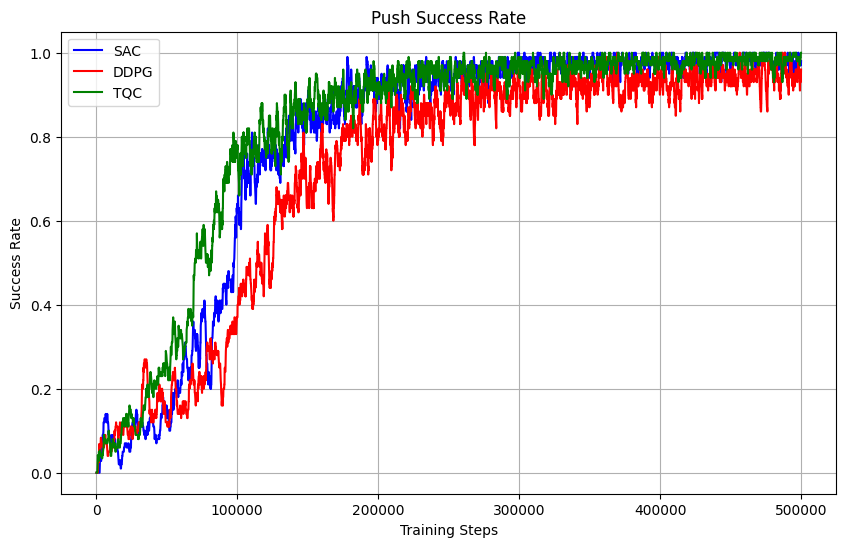

In [5]:


log_dir_1 = './tensorboard/sac_push/SAC_0/'
log_dir_2 = './tensorboard/ddpg_push/DDPG_0/'
log_dir_3 = './tensorboard/tqc_push/TQC_0/'

df1 = load_success_rate(log_dir_1)
df2 = load_success_rate(log_dir_2)
df3 = load_success_rate(log_dir_3)

plt.figure(figsize=(10, 6))

plt.plot(df1['fps'], df1['success_rate'], label='SAC', color='blue')
plt.plot(df2['fps'], df2['success_rate'], label='DDPG', color='red')
plt.plot(df3['fps'], df3['success_rate'], label='TQC', color='green')

plt.xlabel('Training Steps')
plt.ylabel('Success Rate')
plt.title('Push Success Rate')
plt.grid(True)
plt.legend()
plt.show()

Pick Test(SAC)

In [6]:
env = gym.make("FrankaPickSparse", render_mode="human")

model = SAC.load('model/SAC_pick0.zip', env=env)

obs, info = env.reset()

for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

    if done or truncated:
        obs, info = env.reset()

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Pick Test(DDPG)

In [7]:
env = gym.make("FrankaPickSparse", render_mode="human")

model = DDPG.load('model/ddpg_pick0.zip', env=env)

obs, info = env.reset()

for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

    if done or truncated:
        obs, info = env.reset()

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Pick Test(TQC)

In [8]:
env = gym.make("FrankaPickSparse", render_mode="human")

model = TQC.load('model/TQC_pick0.zip', env=env)

obs, info = env.reset()

for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

    if done or truncated:
        obs, info = env.reset()

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Pick Evaluate

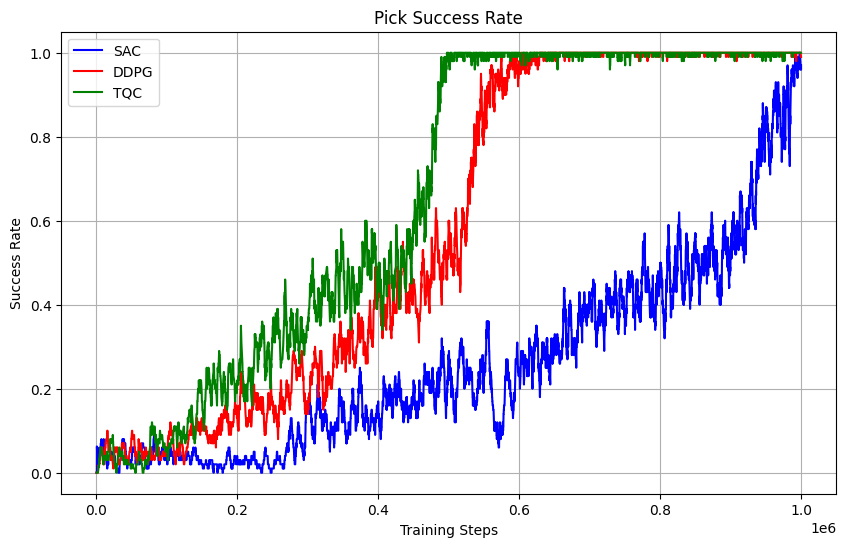

In [9]:
log_dir_4 = './tensorboard/sac_pick/SAC_0/'
log_dir_5 = './tensorboard/ddpg_pick/DDPG_0/'
log_dir_6 = './tensorboard/tqc_pick/TQC_0/'

df1 = load_success_rate(log_dir_4)
df2 = load_success_rate(log_dir_5)
df3 = load_success_rate(log_dir_6)

plt.figure(figsize=(10, 6))

plt.plot(df1['fps'], df1['success_rate'], label='SAC', color='blue')
plt.plot(df2['fps'], df2['success_rate'], label='DDPG', color='red')
plt.plot(df3['fps'], df3['success_rate'], label='TQC', color='green')

plt.xlabel('Training Steps')
plt.ylabel('Success Rate')
plt.title('Pick Success Rate')
plt.grid(True)
plt.legend()
plt.show()